Script for reading the fluorescence images as soon as they get copied to this PC, get the cost and write it into the file "exp_output.txt"

In [1]:
import os
import glob
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler, PatternMatchingEventHandler
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import patches
#import astropy as ap
from astropy.io import fits
#import photutils as pu
from scipy import ndimage
from flask import Flask, jsonify, request
import csv
#import mloop.interfaces as mli
#import mloop.controllers as mlc
#from SingleAtomAnalysiscopy import *
import csv
from datetime import datetime
import pandas as pd
from datetime import datetime

# silence the warnings?
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

In [2]:
# functions for image processing

def get_image_from_file(path):
    """
    read a .fts file and return a numpy array with data.

    Params: path: the path of the image
    """
    with fits.open(path) as hdul:
        data = hdul[0].data
    return data


def show_rois_counts(image_rot, lcrop=5, n_tweezers=2, save_path=None):
    """
    Print the rois on the rotated image.

    Params: image_rot (ndarray)
            lcrop (int): the side length of the rois
    
    Returns:
    """
    shape = np.shape(image_rot)
    lx = shape[0]
    ly = shape[1]
    rois = {}
    rois_bkg = {}
        
    for i in range(0,2):
        key = f'{i}'
        rois[key] = [20+i*8, 12, lcrop]
        rois_bkg[key] = [20+i*8, 12+3*lcrop, lcrop]
    #for i in range(6,11):
    #    key = f'{i-1}'
    #    rois[key] = [18+i*9, 17, lcrop]
    #fig = plt.figure(figsize = (4,4))

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for key, value in rois.items():
        roi = value
        x0 = roi[0]
        y0 = roi[1]
        lcrop = roi[2]
        rect = patches.Rectangle((x0, y0), lcrop, lcrop, edgecolor = 'red', facecolor = "none")
        ax.add_patch(rect)
        ax.text(x0+2, y0+lcrop+4, key, color = 'k', fontsize=16)

    for key, value in rois_bkg.items():
        roi = value
        x0 = roi[0]
        y0 = roi[1]
        lcrop = roi[2]
        rect = patches.Rectangle((x0, y0), lcrop, lcrop, edgecolor = 'black', facecolor = "none")
        ax.add_patch(rect)

    ax_plt = ax.imshow(image_rot, extent = (0, ly, lx, 0))
    im_ratio = image_rot.shape[0]/image_rot.shape[1]
    plt.colorbar(ax_plt, fraction=0.047*im_ratio) #fix the colorbar
    ax.set_axis_off()
    plt.tight_layout()

    plt.show()
    #plt.savefig('Average_image_ROIS_rotate.jpg', dpi = 300)
    
    coord_fluo = np.array([[roi[0], roi[1]] for roi in rois.values()])
    coord_bkg = np.array([[roi[0], roi[1]] for roi in rois_bkg.values()])
    sum_fluo = np.array([np.sum(image_rot[y:y+lcrop, x:x+lcrop]) for x, y in coord_fluo])
    sum_bkg = np.array([np.sum(image_rot[y:y+lcrop, x:x+lcrop]) for x, y in coord_bkg])
    norm_fluo = sum_fluo - sum_bkg
    plt.close(fig)

    return norm_fluo, sum_fluo, sum_bkg

def plot_fluo(path, figsize=(10,6), bkg=True):
    """
    Args: path: csv of the fluorescence counts
    """
    data = pd.read_csv(path, delimiter='\t', comment='#')
    tweez0 = data.iloc[:, 4]
    tweez1 = data.iloc[:, 5]
    plt.figure(figsize=figsize)
    plt.plot(tweez0, linestyle='-', label='tweezer 0')
    plt.plot(tweez1, linestyle='-', label='tweezer 1')
    plt.xlabel('Run index')
    plt.ylabel('Fluo counts')
    plt.title('')
    if bkg: 
        tweez0_bkg = data.iloc[:, 6]
        plt.plot(tweez0_bkg, linestyle='-', label='background', color='grey')
    plt.legend()
    plt.show()

def write_cost(file_path, cost):
    with open(file_path, 'w') as file:
        file.write(f"cost = {cost}\n")

#### Event handler

In [3]:
class FTSEventHandler(PatternMatchingEventHandler):
    def __init__(self, patterns, save_path=None):
        """
        Args: save_path(str): name of the path to save the fluorescence sum, without suffix. 
        """
        super().__init__(patterns=patterns, ignore_directories=True, case_sensitive=False) # idk why but works only if case sensitive is False (default)
        #self.threshold = threshold
        self.save_path = save_path

    def on_created(self, event):
        if event.src_path.endswith("AndorAbs.fts"): clear_output(wait=True) # clear the output after the 2nd image
        print(f"Processing file: {event.src_path}")
        event_name = event.src_path[:-4] #regex
        event_time = datetime.now().strftime("%d_%m_%H:%M:%S") #maybe its in the event name as well

        image = get_image_from_file(event.src_path)
        image_rot = ndimage.rotate(image, -3)[177:217,162:217]#[170:210,154:210]
        norm_fluo, sum_fluo, sum_bkg = show_rois_counts(image_rot, 5, save_path=self.save_path)
        print(f"Tw 0 counts:{norm_fluo[0], sum_fluo[0], sum_bkg[0]}    Tw 1 counts:{norm_fluo[1], sum_fluo[1], sum_bkg[1]}")

        # check if it has enough time to perform it
        if self.save_path is not None:
            if event.src_path.endswith("AndorAbs.fts"): 
                with open(self.save_path+'_1.csv', mode='a', newline='') as file:
                    writer = csv.writer(file, delimiter='\t')
                    writer.writerow([event_name, event_time, norm_fluo[0], norm_fluo[1], sum_fluo[0], sum_fluo[1], sum_bkg[0], sum_bkg[1]])
                plot_fluo(self.save_path+'_1.csv')
            elif event.src_path.endswith("AndorAbs2.fts"): 
                with open(self.save_path+'_2.csv', mode='a', newline='') as file:
                    writer = csv.writer(file, delimiter='\t')
                    writer.writerow([event_name, event_time, norm_fluo[0], norm_fluo[1], sum_fluo[0], sum_fluo[1], sum_bkg[0], sum_bkg[1]])
                plot_fluo(self.save_path+'_2.csv')
    
        # produce the output file
        if event.src_path.endswith("AndorAbs2.fts"): 
            with open("exp_output.txt", 'w') as file:
                if sum_fluo[0] <= np.inf: # no threshold at the moment
                    file.write(f"cost = - {sum_fluo[1]}\n")
                else:
                    file.write(f"bad = {True}\n")
            print("Output written \n")

Run the observer

Processing file: X:\2024\2024-12-18\2024-12-18_14-42-27\R77163_SI__AndorAbs.fts


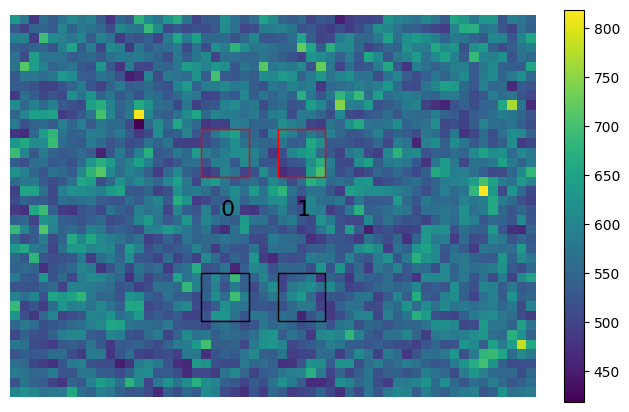

Tw 0 counts:(-244, 14146, 14390)    Tw 1 counts:(700, 14395, 13695)


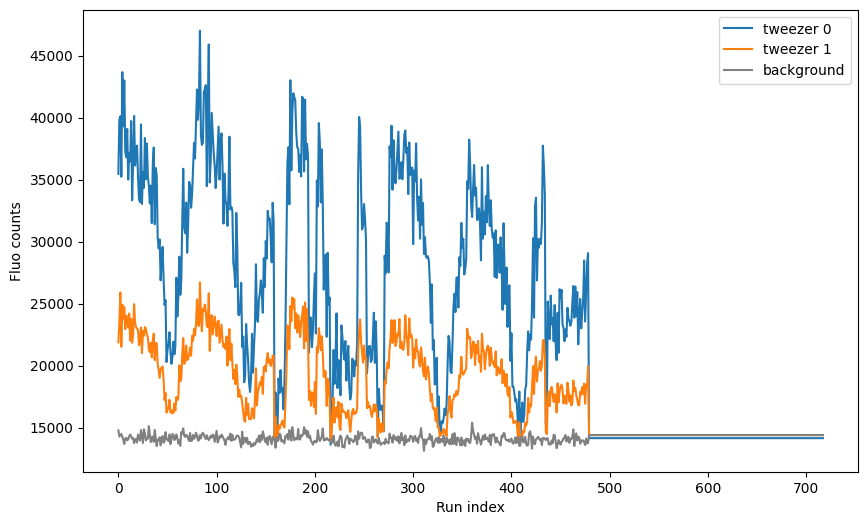

Processing file: X:\2024\2024-12-18\2024-12-18_14-42-27\R77163_SI__AndorAbs2.fts


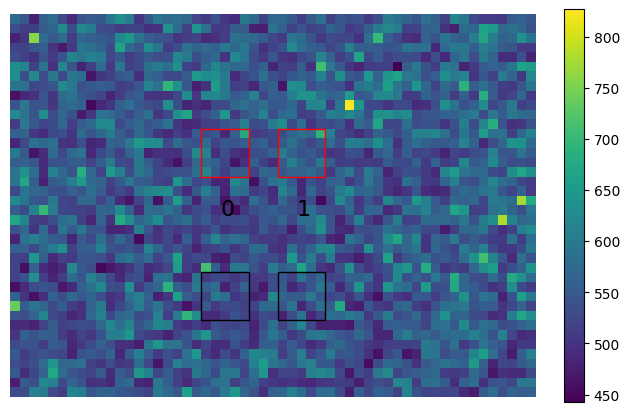

Tw 0 counts:(389, 13574, 13185)    Tw 1 counts:(574, 14173, 13599)


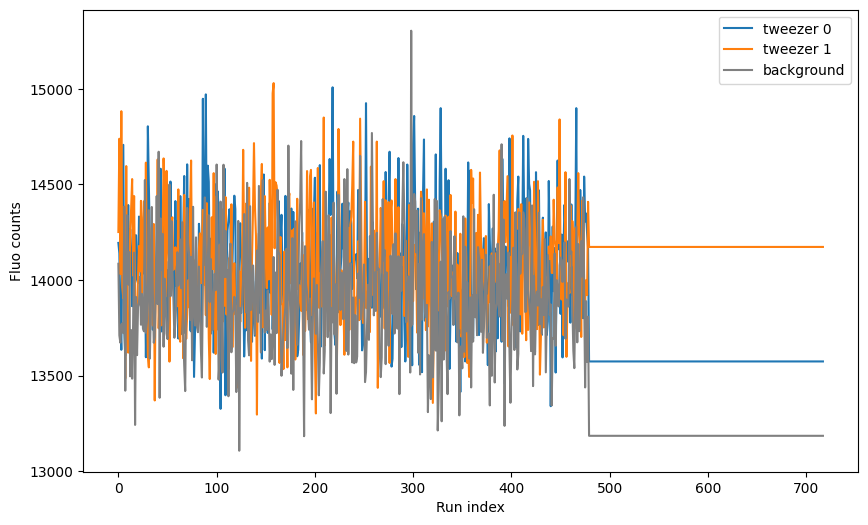

Output written 



In [5]:
# get the parameters from the exp_input file 
current_datetime = datetime.now()
path_to_watch = r"X:\2024\2024-12-18"
pattern = ['R*_AndorAbs.fts','R*_AndorAbs2.fts']
current_time = current_datetime.strftime("%H_%M_%S")
current_date = current_datetime.strftime("%Y_%m_%d")
save_path = f"./fluorescence_measures/fluo_{current_date}_{current_time}_scan_dCollire"

if __name__ == '__main__':
    observer = Observer()
    event_handler = FTSEventHandler(patterns=pattern, save_path=save_path)
    observer.schedule(event_handler, path=path_to_watch, recursive=True)
    observer.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

### Ratatuja

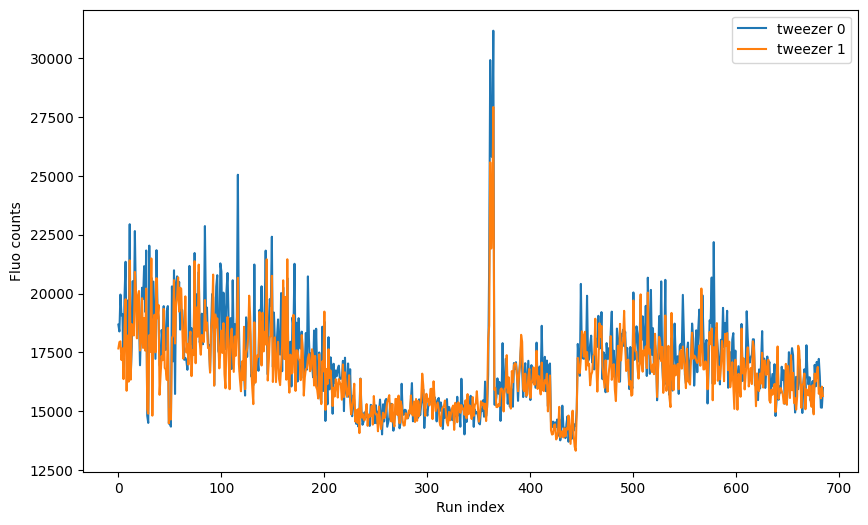

In [ ]:
path = './fluorescence_measures/fluo_2024_12_05_19_45_37_D2_coll40_imag100_newtweezer.csv_1.csv'
path = './fluorescence_measures/fluo_2024_12_09_16_41_39_singleatoms_1.csv'
figsize=(10,6)
data = pd.read_csv(path, delimiter='\t')
tweez0 = data.iloc[:, 2]
tweez1 = data.iloc[:, 3]
plt.figure(figsize=figsize)
plt.plot(tweez0, linestyle='-', label='tweezer 0')
plt.plot(tweez1, linestyle='-', label='tweezer 1')
plt.xlabel('Run index')
plt.ylabel('Fluo counts')
plt.title('')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
path = './fluorescence_measures/fluo_2024_12_05_13_27_40_D2_100ms_ensemble.csv_1.csv'

data = pd.read_csv(path, delimiter='\t')

# Extract the two columns
tweez1 = data.iloc[:, 2]
tweez2 = data.iloc[:, 3]

# Plot the data
plt.figure()
plt.plot(tweez1, linestyle='-')
plt.plot(tweez2, linestyle='-')
plt.xlabel('Run index')
plt.ylabel('Fluo counts')
#plt.title('Plot of Column 1 vs Column 2')
plt.show()

In [ ]:
class FTSEventHandler(PatternMatchingEventHandler):
    def __init__(self, patterns, save_path=None):
        """
        Args: save_path(str): name of the path to save the fluoresce sum, without suffix. 
        """
        super().__init__(patterns=patterns, ignore_directories=True, case_sensitive=False) # idk why but works only if case sensitive is False (default)
        #self.threshold = threshold
        self.save_path = save_path

    def on_created(self, event):
        if event.src_path.endswith("AndorAbs.fts"): clear_output(wait=True) # clear the output after the 2nd image
        print(f"Processing file: {event.src_path}")
        event_name = event.src_path[:-4] #regex
        event_time = datetime.now().strftime("%d_%m_%H:%M:%S") #maybe its in the event name as well

        image = get_image_from_file(event.src_path)
        image_rot = ndimage.rotate(image, -3)[170:210,154:210]#[170:210,154:210]
        sum_fluo = show_rois_counts(image_rot, 5, save_path=self.save_path)
        print(f"Tw 0 counts:{sum_fluo[0]}    Tw 1 counts:{sum_fluo[1]}")

        # check if it has enough time to perform it
        if self.save_path is not None:
            if event.src_path.endswith("AndorAbs.fts"): 
                with open(self.save_path+'_1.csv', mode='a', newline='') as file:
                    writer = csv.writer(file, delimiter='\t')
                    writer.writerow([event_name, event_time, sum_fluo[0], sum_fluo[1]])
            elif event.src_path.endswith("AndorAbs2.fts"): 
                with open(self.save_path+'_2.csv', mode='a', newline='') as file:
                    writer = csv.writer(file, delimiter='\t')
                    writer.writerow([event_name, event_time, sum_fluo[0], sum_fluo[1]])
        

        data = pd.read_csv(self.save_path+'_1.csv', delimiter='\t')

        # Extract the two columns
        tweez1 = data.iloc[:, 2]
        tweez2 = data.iloc[:, 3]

        # Plot the data
        plt.figure(figsize=(6,4))
        plt.plot(tweez1, linestyle='-', label='tweezer 1')
        plt.plot(tweez2, linestyle='-', label='tweezer 2')
        plt.xlabel('Run index')
        plt.ylabel('Fluo counts')
        plt.title('')
        plt.legend()
        plt.show()
            
        # produce the output file
        #if event.src_path.endswith("AndorAbs2.fts"): 
        #    with open("exp_output.txt", 'w') as file:
        #        if sum_fluo[0] <= np.inf: # no threshold at the moment
        #            file.write(f"cost = - {sum_fluo[1]}\n")
        #        else:
        #            file.write(f"bad = {True}\n")
        #    print("Output written \n")